In [1]:
# Cell 1: Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys
from scipy import stats
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Try importing tsfel if installed
try:
    import tsfel
    tsfel_available = True
    print("TSFEL library is available for feature extraction")
except ImportError:
    tsfel_available = False
    print("TSFEL library is not available. Install with: pip install tsfel")

# Add the parent directory to the path to import project modules
sys.path.append('..')
from src import feature_extraction

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12


TSFEL library is available for feature extraction


In [2]:
# %% Cell 2: Load Segmented Heartbeats and PQRST Peaks
# Load previously segmented heartbeats
try:
    heartbeats_file = '../data/processed/heartbeat_segments.npy'
    heartbeats = np.load(heartbeats_file)
    print(f"Loaded {len(heartbeats)} heartbeat segments from {heartbeats_file}")
    
    # Try to load PQRST peak data
    try:
        pqrst_file = '../data/processed/pqrst_peaks.csv'
        pqrst_df = pd.read_csv(pqrst_file)
        print(f"Loaded PQRST peaks from {pqrst_file}")
        pqrst_data_available = True
    except Exception as e:
        print(f"PQRST peak data not found: {e}")
        pqrst_data_available = False
    
except Exception as e:
    print(f"Error loading heartbeat data: {e}")
    # Generate synthetic data
    print("Creating synthetic heartbeat data...")
    
    # Sample rate and heartbeat parameters
    fs = 250  # Hz
    num_beats = 100
    beat_duration = 0.7  # seconds
    samples_per_beat = int(beat_duration * fs)
    
    # Create time array for a single beat
    beat_time = np.linspace(-0.25, 0.45, samples_per_beat)
    
    # Initialize array to store synthetic heartbeats
    heartbeats = np.zeros((num_beats, samples_per_beat))
    
    # Generate synthetic heartbeats with some variation
    for i in range(num_beats):
        # Base ECG pattern with PQRST waves
        p_amp = 0.25 + np.random.normal(0, 0.05)
        q_amp = -0.1 + np.random.normal(0, 0.02)
        r_amp = 1.0 + np.random.normal(0, 0.1)
        s_amp = -0.3 + np.random.normal(0, 0.05)
        t_amp = 0.35 + np.random.normal(0, 0.07)
        
        # P wave (before R)
        p_center = -0.15
        p_width = 0.05
        p_wave = p_amp * np.exp(-((beat_time - p_center) ** 2) / (2 * p_width ** 2))
        
        # QRS complex
        q_center = -0.025
        q_width = 0.02
        q_wave = q_amp * np.exp(-((beat_time - q_center) ** 2) / (2 * q_width ** 2))
        
        r_center = 0
        r_width = 0.03
        r_wave = r_amp * np.exp(-((beat_time - r_center) ** 2) / (2 * r_width ** 2))
        
        s_center = 0.025
        s_width = 0.02
        s_wave = s_amp * np.exp(-((beat_time - s_center) ** 2) / (2 * s_width ** 2))
        
        # T wave (after R)
        t_center = 0.2
        t_width = 0.08
        t_wave = t_amp * np.exp(-((beat_time - t_center) ** 2) / (2 * t_width ** 2))
        
        # Combine waves to form the heartbeat
        heartbeat = p_wave + q_wave + r_wave + s_wave + t_wave
        
        # Add some noise
        heartbeat += np.random.normal(0, 0.02, samples_per_beat)
        
        # Store the synthetic heartbeat
        heartbeats[i] = heartbeat
    
    # Create synthetic PQRST peaks
    pqrst_data_available = False  # No actual PQRST peak data for synthetic beats

# Set fs (sampling frequency)
fs = 360  


Loaded 2271 heartbeat segments from ../data/processed/heartbeat_segments.npy
Loaded PQRST peaks from ../data/processed/pqrst_peaks.csv


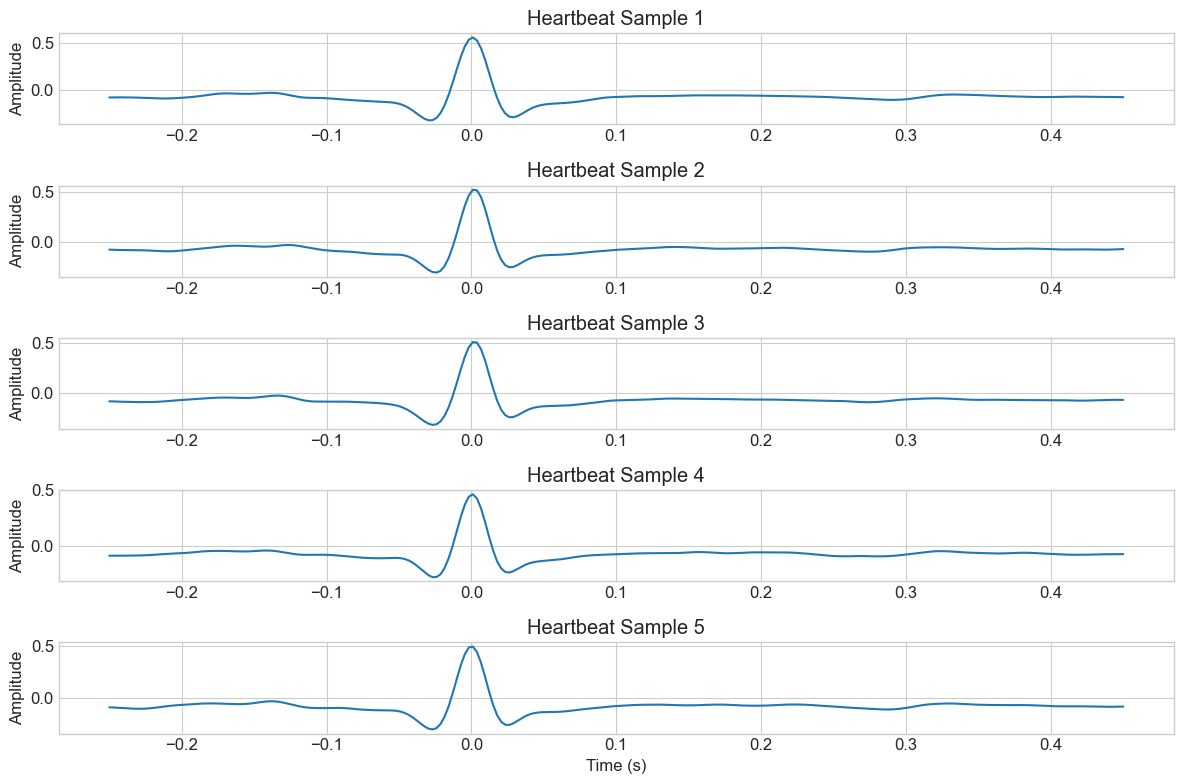

In [3]:
# %% Cell 3: Visualize Sample Heartbeats
# Plot a few sample heartbeats
num_samples = min(5, len(heartbeats))
beat_time = np.linspace(-0.25, 0.45, heartbeats.shape[1])

plt.figure(figsize=(12, 8))
for i in range(num_samples):
    plt.subplot(num_samples, 1, i+1)
    plt.plot(beat_time, heartbeats[i])
    plt.title(f"Heartbeat Sample {i+1}")
    plt.grid(True)
    
    if i == num_samples - 1:
        plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


In [4]:
# %% Cell 4: Extract Statistical Features
def extract_statistical_features(heartbeat):
    """Extract basic statistical features from heartbeat waveform."""
    # Time domain features
    features = {
        'mean': np.mean(heartbeat),
        'std': np.std(heartbeat),
        'min': np.min(heartbeat),
        'max': np.max(heartbeat),
        'range': np.max(heartbeat) - np.min(heartbeat),
        'median': np.median(heartbeat),
        'rms': np.sqrt(np.mean(np.square(heartbeat))),
        'skewness': stats.skew(heartbeat),
        'kurtosis': stats.kurtosis(heartbeat),
        'p5': np.percentile(heartbeat, 5),
        'p25': np.percentile(heartbeat, 25),
        'p75': np.percentile(heartbeat, 75),
        'p95': np.percentile(heartbeat, 95),
        'iqr': np.percentile(heartbeat, 75) - np.percentile(heartbeat, 25),
        'energy': np.sum(np.square(heartbeat)),
    }
    
    # Add zero crossing rate
    zero_crossings = np.where(np.diff(np.signbit(heartbeat)))[0]
    features['zero_crossing_rate'] = len(zero_crossings) / len(heartbeat)
    
    # Add slope features
    slopes = np.diff(heartbeat)
    features['mean_slope'] = np.mean(np.abs(slopes))
    features['max_slope'] = np.max(np.abs(slopes))
    
    return features

# Extract statistical features for all heartbeats
stat_features_list = []
for i, beat in enumerate(heartbeats):
    features = extract_statistical_features(beat)
    stat_features_list.append(features)

# Convert to DataFrame
stat_features_df = pd.DataFrame(stat_features_list)

# Display first few rows
print("Statistical Features:")
print(f"Shape: {stat_features_df.shape}")
display(stat_features_df.head())


Statistical Features:
Shape: (2271, 18)


,mean,std,min,max,range,median,rms,skewness,kurtosis,p5,p25,p75,p95,iqr,energy,zero_crossing_rate,mean_slope,max_slope
0,-0.074350,0.109131,-0.323940,0.555325,0.879265,-0.075664,0.132050,3.135657,15.753961,-0.223919,-0.095867,-0.061343,-0.033882,0.034525,4.394205,0.007937,0.009881,0.141951
1,-0.074769,0.099093,-0.312983,0.524824,0.837807,-0.076849,0.124136,3.428321,18.209129,-0.192209,-0.096561,-0.062694,-0.037269,0.033867,3.883253,0.007937,0.009401,0.148798
2,-0.074677,0.097779,-0.323292,0.507064,0.830355,-0.075432,0.123034,3.239685,17.314547,-0.203141,-0.092286,-0.064956,-0.033003,0.027330,3.814611,0.007937,0.009003,0.142232
3,-0.074497,0.087601,-0.285955,0.463449,0.749405,-0.077338,0.114995,3.445715,18.524435,-0.184347,-0.094386,-0.063606,-0.045881,0.030780,3.332399,0.007937,0.008408,0.134908
4,-0.074647,0.093606,-0.298495,0.490288,0.788783,-0.074590,0.119726,3.377748,17.906310,-0.186690,-0.097472,-0.062726,-0.033811,0.034746,3.612231,0.007937,0.009081,0.141406


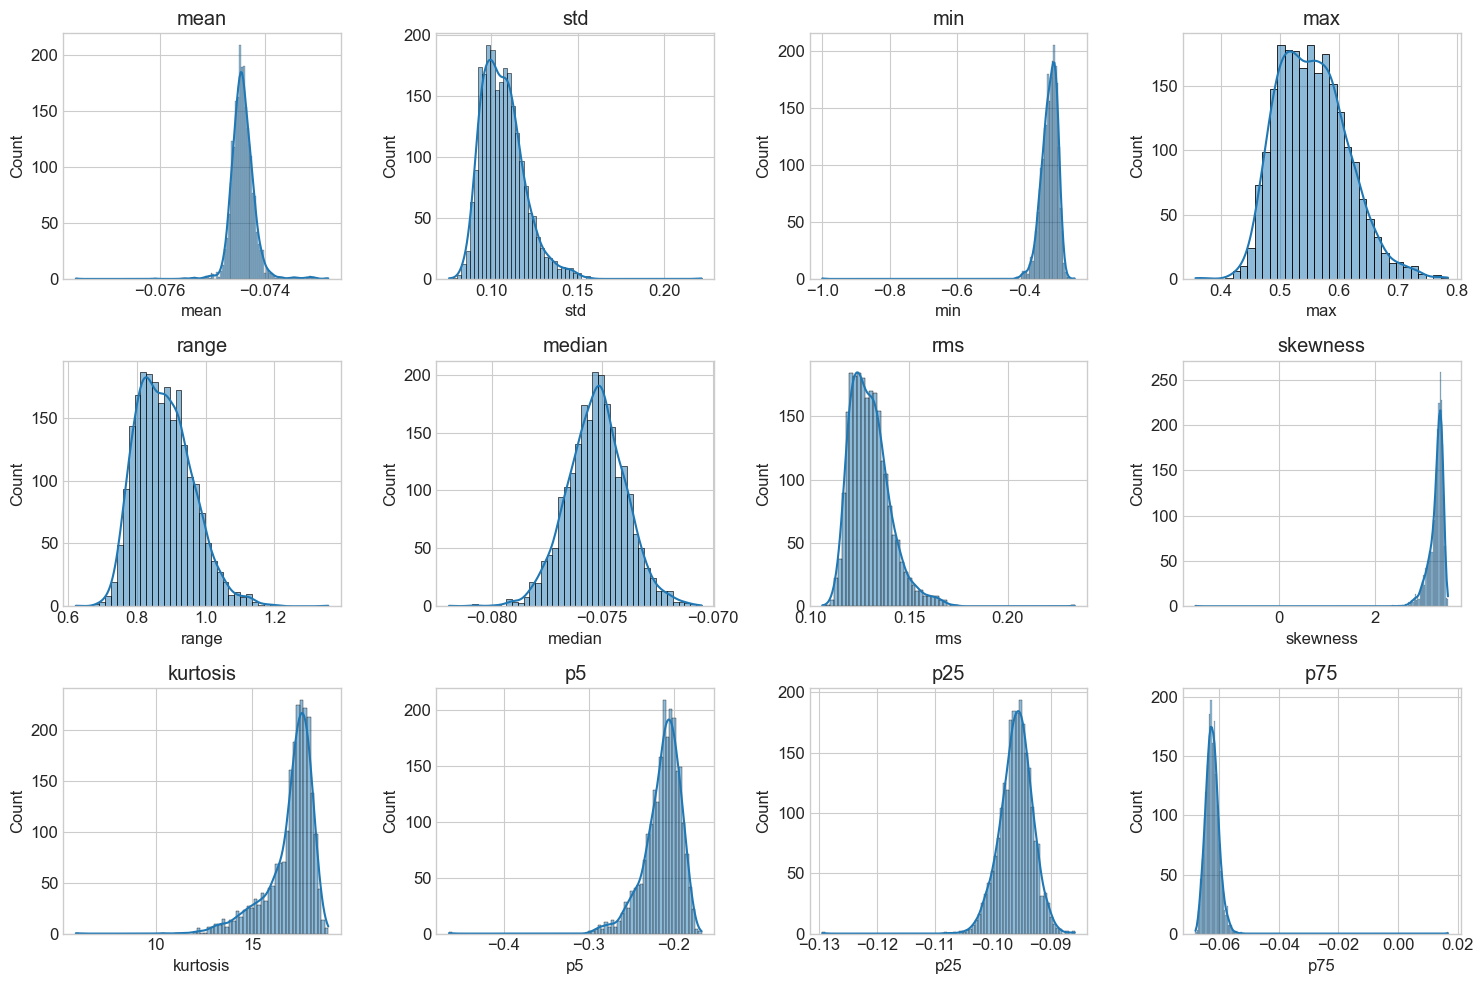

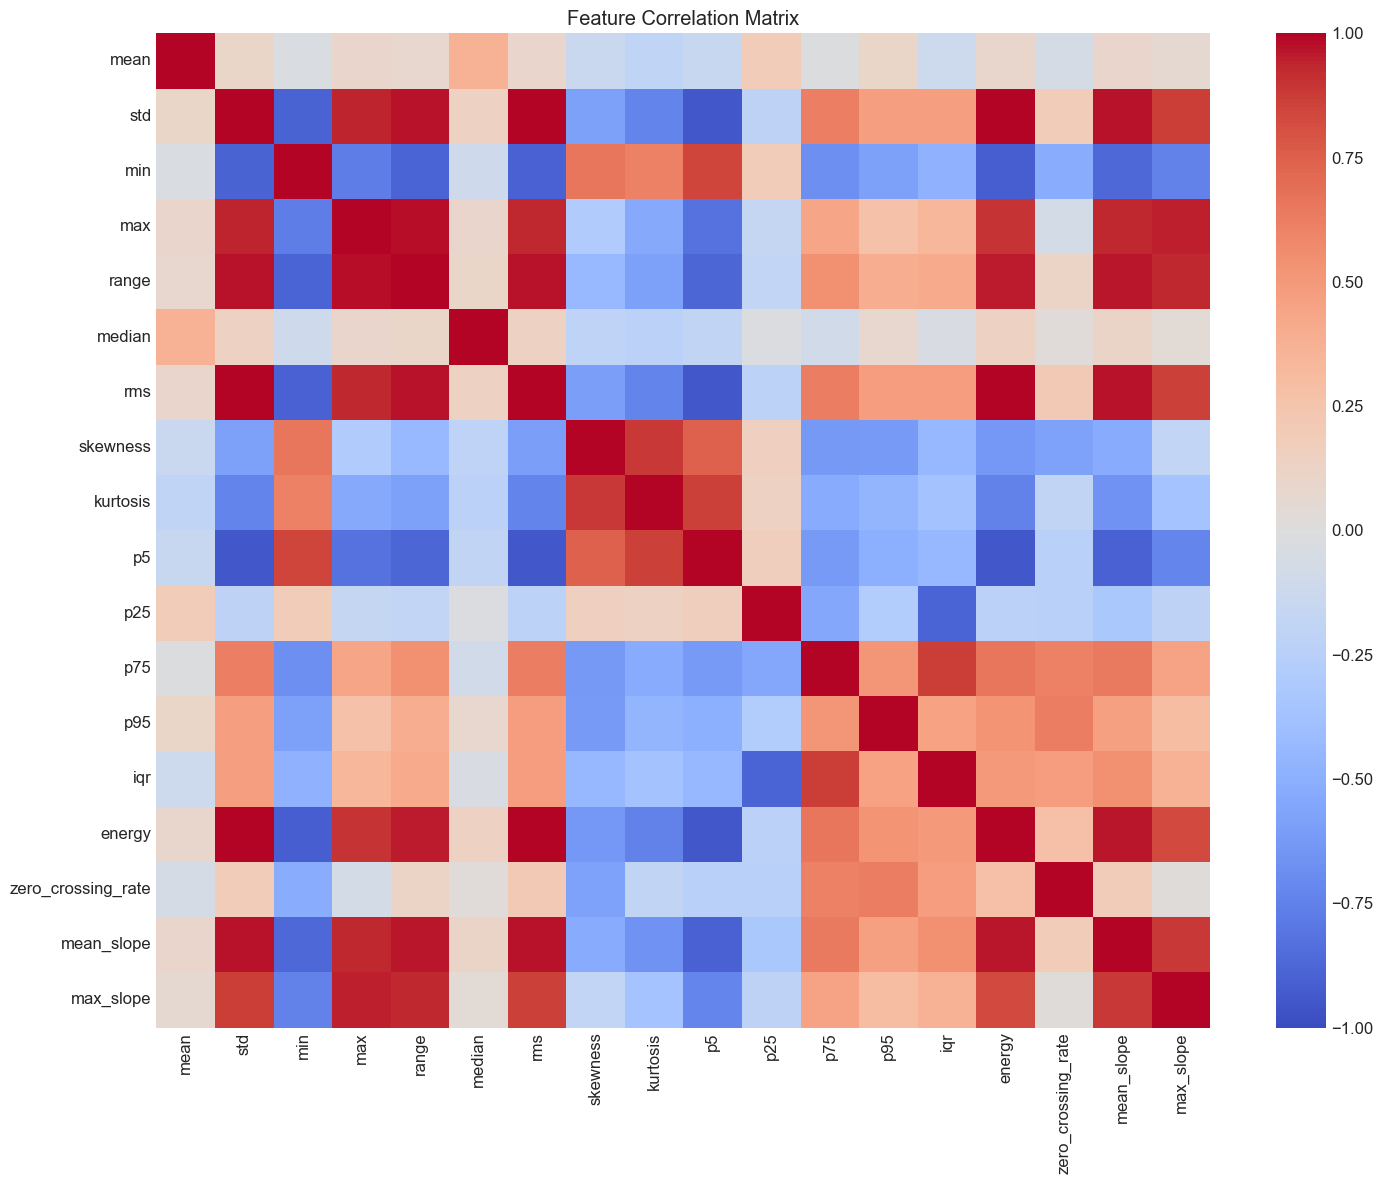

In [5]:
# %% Cell 5: Basic Feature Analysis
# Analyze feature distributions
plt.figure(figsize=(15, 10))
for i, feature in enumerate(stat_features_df.columns[:min(12, len(stat_features_df.columns))]):
    plt.subplot(3, 4, i+1)
    sns.histplot(stat_features_df[feature], kde=True)
    plt.title(feature)
    plt.tight_layout()
plt.show()

# Create correlation matrix of features
plt.figure(figsize=(15, 12))
corr_matrix = stat_features_df.corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

In [6]:
# %% Cell 6: Wavelet-based Features
def extract_wavelet_features(heartbeat, wavelet='db4', levels=4):
    """Extract wavelet-based features from heartbeat."""
    try:
        # Try to import PyWavelets
        import pywt
        
        # Perform wavelet decomposition
        coeffs = pywt.wavedec(heartbeat, wavelet, level=levels)
        
        # Extract features from each coefficient level
        wavelet_features = {}
        for i, coef in enumerate(coeffs):
            level_name = "approx" if i == 0 else f"detail_{i}"
            wavelet_features[f"{level_name}_mean"] = np.mean(coef)
            wavelet_features[f"{level_name}_std"] = np.std(coef)
            wavelet_features[f"{level_name}_energy"] = np.sum(coef**2)
            wavelet_features[f"{level_name}_max"] = np.max(coef)
            wavelet_features[f"{level_name}_min"] = np.min(coef)
        
        return wavelet_features
    
    except ImportError:
        print("PyWavelets not installed. Install with: pip install PyWavelets")
        # Return empty dictionary if PyWavelets is not available
        return {}

# Try to extract wavelet features if PyWavelets is available
try:
    # Extract wavelet features for all heartbeats
    wavelet_features_list = []
    for i, beat in enumerate(heartbeats):
        features = extract_wavelet_features(beat)
        wavelet_features_list.append(features)
    
    # Convert to DataFrame
    if wavelet_features_list and wavelet_features_list[0]:  # Check if features were extracted
        wavelet_features_df = pd.DataFrame(wavelet_features_list)
        
        # Display first few rows
        print("\nWavelet Features:")
        print(f"Shape: {wavelet_features_df.shape}")
        display(wavelet_features_df.head())
        
        wavelet_features_available = True
    else:
        wavelet_features_available = False
        wavelet_features_df = pd.DataFrame()
except Exception as e:
    print(f"Error extracting wavelet features: {e}")
    wavelet_features_available = False
    wavelet_features_df = pd.DataFrame()



Wavelet Features:
Shape: (2271, 25)


,approx_mean,approx_std,approx_energy,approx_max,approx_min,detail_1_mean,detail_1_std,detail_1_energy,detail_1_max,detail_1_min,...,detail_3_mean,detail_3_std,detail_3_energy,detail_3_max,detail_3_min,detail_4_mean,detail_4_std,detail_4_energy,detail_4_max,detail_4_min
0,-0.304003,0.281407,3.775365,0.667643,-1.102753,-0.024670,0.177322,0.705140,0.274287,-0.786024,...,-1.616575e-05,0.011316,0.008708,0.045054,-0.051751,-8.632564e-08,0.000680,0.000060,0.003140,-0.004099
1,-0.307935,0.234458,3.295477,0.476184,-0.999711,-0.015926,0.153249,0.522258,0.199903,-0.668823,...,2.910744e-05,0.014288,0.013882,0.062494,-0.078056,-5.153621e-07,0.000911,0.000107,0.004751,-0.005701
2,-0.312863,0.233745,3.355440,0.460502,-1.013526,-0.019511,0.162003,0.585764,0.183485,-0.723447,...,1.523042e-05,0.013089,0.011649,0.058503,-0.072567,7.923261e-08,0.000830,0.000089,0.004525,-0.005157
3,-0.315050,0.208047,3.135873,0.402918,-0.887143,-0.027310,0.146616,0.489327,0.200211,-0.664933,...,-5.297402e-07,0.012724,0.011009,0.059595,-0.052878,6.975615e-07,0.000834,0.000090,0.003766,-0.005507
4,-0.316285,0.226227,3.326727,0.460984,-0.946814,-0.033357,0.163910,0.615544,0.230632,-0.734626,...,2.294241e-05,0.012897,0.011311,0.061368,-0.047992,2.005248e-07,0.000838,0.000091,0.003747,-0.005454


In [7]:
# %% Cell 7: TSFEL Feature Extraction (if available)
if tsfel_available:
    # Get TSFEL features configuration for time domain
    cfg_time = tsfel.get_features_by_domain("temporal")
    
    # Extract TSFEL features for all heartbeats
    print("Extracting TSFEL features (this may take a while)...")
    
    # Define a function to extract features for a single heartbeat
    def extract_tsfel_features(heartbeat, fs):
        # Extract features with TSFEL
        features = tsfel.time_series_features_extractor(cfg_time, heartbeat, fs=fs, verbose=0)
        return features
    
    # Extract features in a loop
    tsfel_features_list = []
    for i, beat in enumerate(heartbeats[:min(100, len(heartbeats))]):  # Limit number of beats for performance
        features_df = extract_tsfel_features(beat, fs)
        tsfel_features_list.append(features_df.iloc[0].to_dict())
        
        # Print progress
        if (i+1) % 10 == 0:
            print(f"Processed {i+1}/{min(100, len(heartbeats))} heartbeats...")
    
    # Convert to DataFrame
    tsfel_features_df = pd.DataFrame(tsfel_features_list)
    
    # Remove any constant or NaN columns
    tsfel_features_df = tsfel_features_df.loc[:, tsfel_features_df.nunique() > 1]
    tsfel_features_df = tsfel_features_df.dropna(axis=1)
    
    # Display first few rows
    print("\nTSFEL Features:")
    print(f"Shape: {tsfel_features_df.shape}")
    display(tsfel_features_df.head())
    
    tsfel_features_available = True
else:
    print("TSFEL not available. Skipping TSFEL feature extraction.")
    tsfel_features_available = False
    tsfel_features_df = pd.DataFrame()

Extracting TSFEL features (this may take a while)...
Processed 10/100 heartbeats...
Processed 20/100 heartbeats...
Processed 30/100 heartbeats...
Processed 40/100 heartbeats...
Processed 50/100 heartbeats...
Processed 60/100 heartbeats...
Processed 70/100 heartbeats...
Processed 80/100 heartbeats...
Processed 90/100 heartbeats...
Processed 100/100 heartbeats...

TSFEL Features:
Shape: (100, 13)


,0_Area under the curve,0_Autocorrelation,0_Centroid,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff
0,0.072109,5.0,0.280527,0.009881,0.000013,0.001772,-0.000405,8.0,5.0,9.0,251.098008,0.000003,2.480016
1,0.069650,5.0,0.284668,0.009401,0.000024,0.002030,-0.000168,9.0,7.0,8.0,251.096040,0.000005,2.359744
2,0.069283,5.0,0.284076,0.009003,0.000056,0.001373,-0.000168,8.0,4.0,8.0,251.089008,0.000005,2.259823
3,0.066915,5.0,0.291395,0.008408,0.000059,0.001700,0.000282,12.0,6.0,11.0,251.077879,-0.000002,2.110320
4,0.068254,5.0,0.286743,0.009081,0.000027,0.002003,-0.000192,11.0,7.0,10.0,251.085661,0.000004,2.279223


In [8]:
# %% Cell 8: Morphological Features (if PQRST peaks available)
def extract_morphological_features(heartbeat, fs=250):
    """Extract morphological features based on ECG waveform shape."""
    # Default 'reference' locations if no PQRST data available
    beat_time = np.linspace(-0.25, 0.45, len(heartbeat))
    
    # Find potential PQRST points in the heartbeat
    p_idx = np.argmax(heartbeat[:int(0.2*len(heartbeat))])
    q_idx = np.argmin(heartbeat[int(0.2*len(heartbeat)):int(0.25*len(heartbeat))]) + int(0.2*len(heartbeat))
    r_idx = np.argmax(heartbeat[int(0.25*len(heartbeat))-10:int(0.25*len(heartbeat))+10]) + int(0.25*len(heartbeat))-10
    s_idx = np.argmin(heartbeat[r_idx:r_idx+int(0.05*len(heartbeat))]) + r_idx
    t_idx = np.argmax(heartbeat[s_idx:s_idx+int(0.2*len(heartbeat))]) + s_idx
    
    # Calculate morphological features
    features = {}
    
    # Wave amplitudes
    features['p_amp'] = heartbeat[p_idx]
    features['q_amp'] = heartbeat[q_idx]
    features['r_amp'] = heartbeat[r_idx]
    features['s_amp'] = heartbeat[s_idx]
    features['t_amp'] = heartbeat[t_idx]
    
    # Wave-to-wave amplitudes
    features['pq_amp'] = features['p_amp'] - features['q_amp']
    features['rs_amp'] = features['r_amp'] - features['s_amp']
    features['rt_amp'] = features['r_amp'] - features['t_amp']
    features['st_amp'] = features['s_amp'] - features['t_amp']
    
    # Time intervals (in seconds)
    features['pq_interval'] = (q_idx - p_idx) / fs
    features['qrs_interval'] = (s_idx - q_idx) / fs
    features['qt_interval'] = (t_idx - q_idx) / fs
    features['st_interval'] = (t_idx - s_idx) / fs
    
    # Slopes
    if q_idx > p_idx:
        features['p_q_slope'] = (heartbeat[q_idx] - heartbeat[p_idx]) / ((q_idx - p_idx) / fs)
    else:
        features['p_q_slope'] = 0
        
    if r_idx > q_idx:
        features['q_r_slope'] = (heartbeat[r_idx] - heartbeat[q_idx]) / ((r_idx - q_idx) / fs)
    else:
        features['q_r_slope'] = 0
        
    if s_idx > r_idx:
        features['r_s_slope'] = (heartbeat[s_idx] - heartbeat[r_idx]) / ((s_idx - r_idx) / fs)
    else:
        features['r_s_slope'] = 0
        
    if t_idx > s_idx:
        features['s_t_slope'] = (heartbeat[t_idx] - heartbeat[s_idx]) / ((t_idx - s_idx) / fs)
    else:
        features['s_t_slope'] = 0
    
    # Overall wave prominence
    features['r_prominence'] = features['r_amp'] - min(features['q_amp'], features['s_amp'])
    features['p_prominence'] = features['p_amp'] - min(heartbeat[:p_idx]) if p_idx > 0 else 0
    features['t_prominence'] = features['t_amp'] - min(heartbeat[s_idx:t_idx]) if t_idx > s_idx else 0
    
    return features

# Extract morphological features for all heartbeats
morph_features_list = []
for i, beat in enumerate(heartbeats):
    features = extract_morphological_features(beat, fs)
    morph_features_list.append(features)

# Convert to DataFrame
morph_features_df = pd.DataFrame(morph_features_list)

# Display first few rows
print("\nMorphological Features:")
print(f"Shape: {morph_features_df.shape}")
display(morph_features_df.head())


Morphological Features:
Shape: (2271, 20)


,p_amp,q_amp,r_amp,s_amp,t_amp,pq_amp,rs_amp,rt_amp,st_amp,pq_interval,qrs_interval,qt_interval,st_interval,p_q_slope,q_r_slope,r_s_slope,s_t_slope,r_prominence,p_prominence,t_prominence
0,-0.032789,-0.115050,-0.088114,-0.119800,0.555325,0.082262,0.031686,-0.643439,-0.675125,0.061111,0.005556,0.077778,0.072222,-1.346098,0.0,-1.037012,9.347890,0.031686,0.059980,0.879265
1,-0.034035,-0.111054,-0.084768,-0.119281,0.524824,0.077020,0.034512,-0.609592,-0.644105,0.050000,0.005556,0.077778,0.072222,-1.540396,0.0,-1.129498,8.918373,0.034512,0.063674,0.837807
2,-0.030201,-0.095742,-0.089916,-0.109888,0.507064,0.065541,0.019972,-0.596980,-0.616951,0.055556,0.016667,0.077778,0.061111,-1.179741,0.0,-0.653620,10.095567,0.019972,0.065073,0.830355
3,-0.044940,-0.108501,-0.082920,-0.112604,0.463449,0.063561,0.029684,-0.546369,-0.576053,0.063889,0.005556,0.077778,0.072222,-0.994860,0.0,-0.971466,7.976117,0.029684,0.047128,0.749405
4,-0.029978,-0.107968,-0.093054,-0.116243,0.490288,0.077991,0.023189,-0.583342,-0.606531,0.061111,0.013889,0.077778,0.063889,-1.276209,0.0,-0.758904,9.493527,0.023189,0.071534,0.788783


In [9]:
# %% Cell 9: Combine Features
# Create a combined feature set from all available feature types
feature_dfs = [stat_features_df, morph_features_df]

if wavelet_features_available:
    feature_dfs.append(wavelet_features_df)

if tsfel_features_available:
    feature_dfs.append(tsfel_features_df)

# Combine features
combined_features = pd.concat(feature_dfs, axis=1)

# Check for and handle any duplicate columns
if len(combined_features.columns) != len(set(combined_features.columns)):
    print("Warning: Duplicate column names found. Renaming duplicates...")
    combined_features = combined_features.loc[:,~combined_features.columns.duplicated()]

# Handle NaN values (fill with mean)
combined_features = combined_features.fillna(combined_features.mean())

# Print combined feature set info
print("\nCombined Feature Set:")
print(f"Total Features: {combined_features.shape[1]}")
print(f"Number of Samples: {combined_features.shape[0]}")
display(combined_features.head())



Combined Feature Set:
Total Features: 76
Number of Samples: 2271


,mean,std,min,max,range,median,rms,skewness,kurtosis,p5,...,0_Mean absolute diff,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff
0,-0.074350,0.109131,-0.323940,0.555325,0.879265,-0.075664,0.132050,3.135657,15.753961,-0.223919,...,0.009881,0.000013,0.001772,-0.000405,8.0,5.0,9.0,251.098008,0.000003,2.480016
1,-0.074769,0.099093,-0.312983,0.524824,0.837807,-0.076849,0.124136,3.428321,18.209129,-0.192209,...,0.009401,0.000024,0.002030,-0.000168,9.0,7.0,8.0,251.096040,0.000005,2.359744
2,-0.074677,0.097779,-0.323292,0.507064,0.830355,-0.075432,0.123034,3.239685,17.314547,-0.203141,...,0.009003,0.000056,0.001373,-0.000168,8.0,4.0,8.0,251.089008,0.000005,2.259823
3,-0.074497,0.087601,-0.285955,0.463449,0.749405,-0.077338,0.114995,3.445715,18.524435,-0.184347,...,0.008408,0.000059,0.001700,0.000282,12.0,6.0,11.0,251.077879,-0.000002,2.110320
4,-0.074647,0.093606,-0.298495,0.490288,0.788783,-0.074590,0.119726,3.377748,17.906310,-0.186690,...,0.009081,0.000027,0.002003,-0.000192,11.0,7.0,10.0,251.085661,0.000004,2.279223


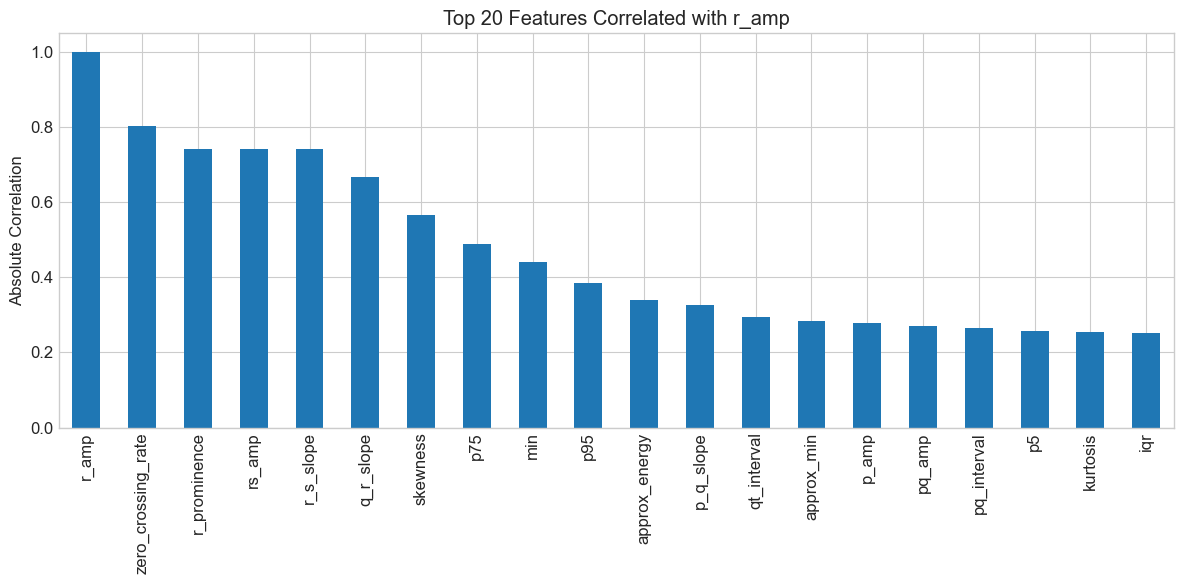

In [10]:
# %% Cell 10: Feature Selection - Correlation Analysis
# Calculate correlation with key features (e.g., morphological)
if 'r_amp' in combined_features.columns:
    key_feature = 'r_amp'
elif 'max' in combined_features.columns:
    key_feature = 'max'
else:
    key_feature = combined_features.columns[0]

# Calculate correlations with the key feature
correlations = combined_features.corrwith(combined_features[key_feature])
sorted_correlations = correlations.abs().sort_values(ascending=False)

# Plot top correlations
plt.figure(figsize=(12, 6))
sorted_correlations[:20].plot(kind='bar')
plt.title(f'Top 20 Features Correlated with {key_feature}')
plt.ylabel('Absolute Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()


In [11]:
# %% Cell 11: Feature Selection - Remove Highly Correlated Features
def remove_highly_correlated_features(df, threshold=0.95):
    """
    Remove highly correlated features from the dataset.
    
    Parameters:
        df: DataFrame of features
        threshold: Correlation threshold above which to remove features
        
    Returns:
        DataFrame with highly correlated features removed
    """
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()
    
    # Create an upper triangle mask
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    
    print(f"Dropping {len(to_drop)} highly correlated features")
    
    # Drop highly correlated features
    df_filtered = df.drop(columns=to_drop)
    
    return df_filtered

# Apply correlation-based feature selection
filtered_features = remove_highly_correlated_features(combined_features)

print(f"Features remaining after correlation filtering: {filtered_features.shape[1]}")
display(filtered_features.head())

Dropping 24 highly correlated features
Features remaining after correlation filtering: 52


,mean,std,min,max,median,skewness,kurtosis,p25,p75,p95,...,0_Area under the curve,0_Autocorrelation,0_Mean diff,0_Median absolute diff,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Positive turning points,0_Signal distance,0_Slope
0,-0.074350,0.109131,-0.323940,0.555325,-0.075664,3.135657,15.753961,-0.095867,-0.061343,-0.033882,...,0.072109,5.0,0.000013,0.001772,-0.000405,8.0,5.0,9.0,251.098008,0.000003
1,-0.074769,0.099093,-0.312983,0.524824,-0.076849,3.428321,18.209129,-0.096561,-0.062694,-0.037269,...,0.069650,5.0,0.000024,0.002030,-0.000168,9.0,7.0,8.0,251.096040,0.000005
2,-0.074677,0.097779,-0.323292,0.507064,-0.075432,3.239685,17.314547,-0.092286,-0.064956,-0.033003,...,0.069283,5.0,0.000056,0.001373,-0.000168,8.0,4.0,8.0,251.089008,0.000005
3,-0.074497,0.087601,-0.285955,0.463449,-0.077338,3.445715,18.524435,-0.094386,-0.063606,-0.045881,...,0.066915,5.0,0.000059,0.001700,0.000282,12.0,6.0,11.0,251.077879,-0.000002
4,-0.074647,0.093606,-0.298495,0.490288,-0.074590,3.377748,17.906310,-0.097472,-0.062726,-0.033811,...,0.068254,5.0,0.000027,0.002003,-0.000192,11.0,7.0,10.0,251.085661,0.000004


PCA reduced dimensions from 52 to 21
Explained variance ratio: [0.21974907 0.13211303 0.08760933 0.06187472 0.06016916 0.05566791
 0.04386079 0.03839171 0.03494749 0.02991534 0.02575294 0.02362537
 0.02300885 0.02080902 0.01774161 0.0157371  0.01556301 0.01450561
 0.01084922 0.00993781 0.00913102]


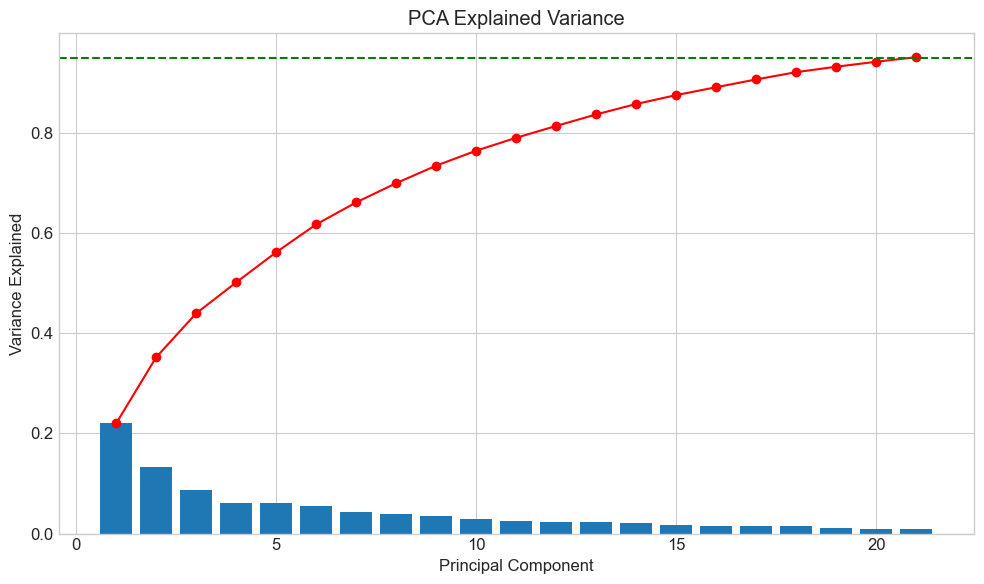

In [12]:
# %% Cell 12: Dimension Reduction with PCA
# Standardize features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(filtered_features)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
pca_result = pca.fit_transform(scaled_features)

print(f"PCA reduced dimensions from {filtered_features.shape[1]} to {pca_result.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         np.cumsum(pca.explained_variance_ratio_), 'r-o')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('PCA Explained Variance')
plt.axhline(y=0.95, color='g', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.show()

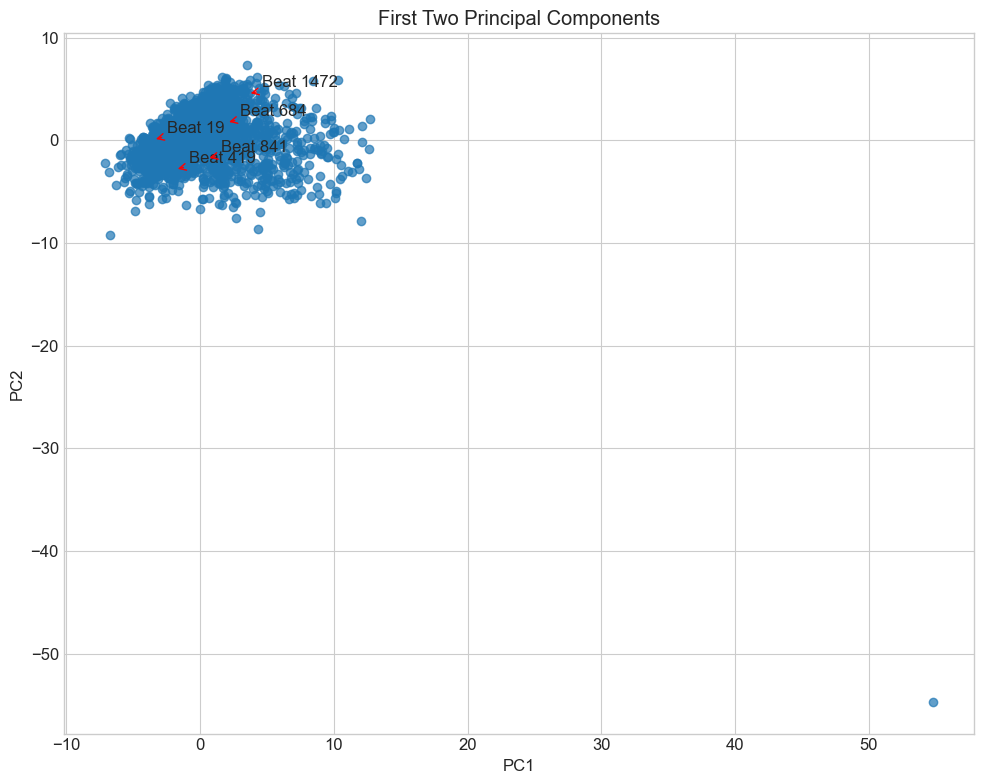

In [13]:
# %% Cell 13: Visualize Data in PCA Space
# Plot first two principal components
plt.figure(figsize=(10, 8))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.7)
plt.title('First Two Principal Components')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)

# Add some sample points as annotations
num_samples = 5
for i in range(num_samples):
    idx = np.random.randint(0, len(pca_result))
    plt.annotate(f"Beat {idx}", (pca_result[idx, 0], pca_result[idx, 1]),
                 xytext=(10, 5), textcoords='offset points',
                 arrowprops=dict(arrowstyle='->', color='red'))

plt.tight_layout()
plt.show()

In [14]:
# %% Cell 14: Save Extracted Features
# Create output directory if it doesn't exist
output_dir = '../data/features'
os.makedirs(output_dir, exist_ok=True)

# Save all feature sets
combined_features.to_csv(os.path.join(output_dir, 'combined_features.csv'), index=False)
print(f"Saved combined features to {os.path.join(output_dir, 'combined_features.csv')}")

filtered_features.to_csv(os.path.join(output_dir, 'filtered_features.csv'), index=False)
print(f"Saved filtered features to {os.path.join(output_dir, 'filtered_features.csv')}")

# Save PCA results
pca_df = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])
pca_df.to_csv(os.path.join(output_dir, 'pca_features.csv'), index=False)
print(f"Saved PCA features to {os.path.join(output_dir, 'pca_features.csv')}")

# Save PCA model (using pickle)
import pickle
with open(os.path.join(output_dir, 'pca_model.pkl'), 'wb') as f:
    pickle.dump(pca, f)
with open(os.path.join(output_dir, 'scaler_model.pkl'), 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved PCA and scaler models to {output_dir}")

print("Feature extraction completed successfully!")

Saved combined features to ../data/features\combined_features.csv
Saved filtered features to ../data/features\filtered_features.csv
Saved PCA features to ../data/features\pca_features.csv
Saved PCA and scaler models to ../data/features
Feature extraction completed successfully!
